In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy import pi, sin, cos, arcsin, dot

class ThinFilm_model:
    def __init__(self, ambient, thinfilm, substrate, wl, angle = 0):
        self.wavelength = wl
        self.ambient = chromatic_n(ambient['a'], self.wavelength)
        self.substrate = chromatic_n(substrate['s'], self.wavelength)
        self.thinfilm = thinfilm
        self.angle = angle*pi/180
        
    def eq_tf_matrix(self, pl):
        eq_matrix = identity_matrix(self.wavelength)
        for i in range(np.size(self.thinfilm)):
            eq_matrix = matrix_dot(
                tf_matrix(self.thinfilm[-i-1], self.wavelength, 
                          pl, self.ambient, self.angle), eq_matrix)
        return eq_matrix

    def eq_admittance(self, pl):
        eq_matrix = self.eq_tf_matrix(pl)
        theta_s = arcsin(self.ambient/self.substrate*sin(self.angle))
        if pl == "S":
            eq_y = bc(eq_matrix, self.substrate*cos(theta_s)/cos(self.angle), wl)
        elif pl == "P":
            eq_y = bc(eq_matrix, self.substrate*cos(self.angle)/cos(theta_s), wl)
        else:
            eq_y = bc(eq_matrix, self.substrate, wl)
        Y = eq_y['C']/eq_y['B']
        return Y.values.reshape(np.size(self.wavelength), 1)
        
    def reflectance(self, pl):
        eq_Y = self.eq_admittance(pl).flatten()
        r = (self.ambient-eq_Y)/(self.ambient+eq_Y)
        reflectance = np.reshape(r*r.conjugate(), np.size(eq_Y))
        return np.real(reflectance)
    
    def R(self):
        if self.angle != 0:
            R_S = self.reflectance("S")
            R_P = self.reflectance("P")
            return oblique_incident(R_S, R_P)
        else:
            R = self.reflectance("non")
            return oblique_incident(R, R)

class oblique_incident:
    def __init__(self, S, P):
        self.S = S
        self.P = P
        self.avg = S+P/2
    
def bc(eq, ns, wl):
    m = np.size(wl)
    ita_s = np.reshape(pd.DataFrame({"one":np.ones(m),"ita":ns}).values.reshape(-1, 1), (m, 2, 1))
    YY = [dot(eq[i], ita_s[i]) for i in range(m)]
    bc = pd.DataFrame(np.reshape(YY, (m,2)), columns = ['B','C'])
    return bc

def chromatic_n(m, wl, pl=0, n0=0, theta0=0):
    n, k = globals()[material[m]['type']](material[m], wl)
    theta_n = arcsin(n0*sin(theta0)/n)
    if pl == "S":
        return (n - 1j*k)*cos(theta_n)/cos(theta0)
    elif pl == "P":
        return (n - 1j*k)*cos(theta0)/cos(theta_n)
    else:
        return n - 1j*k

def tf_matrix(layer, wl, pl, n0, theta0):
    m = matrix(layer['m'], layer['d'], wl, pl, n0, theta0)
    return m

def matrix(m, t, wl, pl, n0, theta0):
    ita = chromatic_n(m, wl, pl, n0, theta0) 
    if pl == "S" or pl == "P":
        delta = 2*pi*ita*t/wl*cos(theta0)
    else:
        delta = 2*pi*ita*t/wl
    element = matrix_element(ita, delta)
    return np.reshape(element.values.reshape(1,-1), (np.size(wl), 2, 2))

def matrix_element(ita, delta):
    e = pd.DataFrame(
        {'e1':cos(delta), 'e2':1j/ita*sin(delta), 
         'e3':1j*ita*sin(delta), 'e4':cos(delta)})
    return e
    
def matrix_dot(layer_up, layer_bot): 
    w, _, _ = np.shape(layer_up)
    eq = [dot(layer_up[i], layer_bot[i]) for i in range(w)]
    return eq

def identity_matrix(wl):
    m = np.size(wl)
    i = pd.DataFrame({'e1':np.ones(m), 'e2':np.zeros(m), 'e3':np.zeros(m), 'e4':np.ones(m)})
    i_matrix = np.reshape(i.values.reshape(1,-1), (m, 2, 2))
    return i_matrix

In [24]:
material = {
    'TiO2':{'A':5.913, 'B':0.2441, 'C':0.0803, 'type':'TiO2'},
    'SiO2':{'A':0.6961663,'B':0.0684043,'C':0.4079426,'D':0.1162414,'E':0.8974794,'F':9.896161, 'type':'SiO2'},
    'sodalime':{'type':'sodalime', 'material':'sodalime', 'A':1.5130, 'B':0.003169, 'C':0.003962},
    'air':{'type':'air', 'material':'air'},
    'ITO':{'type':'ITO', 'material':'ITO'},
    'SiN':{'type':'SiN', 'material':'SiN'},
    'acrylic':{'A':1.1819, 'B':0.011313, 'type':'acrylic'},
    'acrylic_h':{'type':'acrylic_h'},
    'polymide':{'type':'polymide'},
    'CrYAG':{'type':'CrYAG'}
}
def sodalime(m, x):
    x = x/1000
    n = m['A']-m['B']*x**2+m['C']*x**-2
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_k = interp1d([float(i) for i in file['wl']], [float(i) for i in file['k']])
    return n, f_k(x)

def ITO(m, x):
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_n = interp1d([float(i) for i in file[:381]['wl']], [float(i) for i in file[:381]['n']])
    f_k = interp1d([float(i) for i in file[:381]['wl']], [float(i) for i in file[382:]['n']])
    return f_n(x/1000), f_k(x/1000)

def SiN(m,x):
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_n = interp1d([float(i) for i in file[:146]['wl']], [float(i) for i in file[:146]['n']])
    f_k = interp1d([float(i) for i in file[:146]['wl']], [float(i) for i in file[147:]['n']])
    return f_n(x/1000), f_k(x/1000)

def TiO2(m, x):
    x = x/1000
    n = (m['A']+m['B']/(x**2-m['C']))**.5
    k = np.zeros(np.size(x))
    return n, k

def SiO2(m, x):
    x = x/1000
    n = (1+m['A']/(1-(m['B']/x)**2)+m['C']/(1-(m['D']/x)**2)+m['E']/(1-(m['F']/x)**2))**.5
    k = np.zeros(np.size(x))
    return n, k

def acrylic(m, x):
    x = x/1000
    n = (1+m['A']/(1-m['B']/x**2))**.5
    k = np.zeros(np.size(x))
    return n, k

def acrylic_h(m, x):
    n = 1.8*np.ones(np.size(x))
    k = 0*np.ones(np.size(x))
    return n, k

def CrYAG(m, x):
    n = 1.8*np.ones(np.size(x))
    k = 0*np.ones(np.size(x))
    return n, k

def polymide(m, x):
    n = 1.5*np.ones(np.size(x))
    k = np.zeros(np.size(x))
    return n, k

def air(m, x):
    n = np.ones(np.size(x))
    k = np.zeros(np.size(x))
    return n, k

def sec_reflec(T_measure, n0, ns):
    T_sec = 1-((n0-ns)/(n0+ns))**2
    return (100/T_measure - 1/T_sec + 1)**-1

def trans(n0, n1):
    return 1-((n0-n1)/(n0+n1))**2

In [5]:
T_OCA_GG3 = trans(1.48, 1.47)
file = pd.read_csv(r'.\DX\Glass_0T.csv')
file_c = pd.read_csv(r'.\DX\DX-MP-1_0T.csv')
wl = file['nm']
TA_glass = sec_reflec(file['SCAN'], 1, 1.47)
TA_DX = sec_reflec(file_c['SCAN'], 1, 1.47)
f_gg3 = interp1d(wl, TA_glass)
f_dx = interp1d(wl, TA_DX)

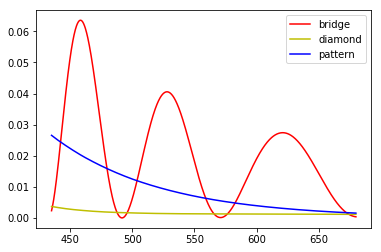

In [32]:
d_SiN = 10
d_SiO2 = 50
start_wl = 435
end_wl = 680
wl = np.linspace(start_wl, end_wl, 1000)

bridge = ThinFilm_model(
    {'a': 'polymide'}, [
        {'m': 'acrylic', 'd': 800},
        {'m': 'SiN', 'd': d_SiN},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'ITO', 'd':23},
        {'m': 'acrylic', 'd':1200},
        {'m': 'ITO', 'd':23},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiN', 'd': d_SiN}
    ], {'s': 'sodalime'}, wl)

ITO_layer = ThinFilm_model(
    {'a': 'polymide'}, [
        {'m': 'polymide', 'd': 2000},
        {'m': 'SiN', 'd': d_SiN},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'ITO', 'd':23},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiN', 'd': d_SiN}
    ], {'s': 'sodalime'}, wl)

pattern = ThinFilm_model(
    {'a': 'polymide'}, [
        {'m': 'polymide', 'd': 2000},
        {'m': 'SiN', 'd': d_SiN},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiN', 'd': d_SiN}
    ], {'s': 'sodalime'}, wl)


R_b = bridge.R().avg
R_ITO = ITO_layer.R().avg
R_p = pattern.R().avg

plt.plot(wl, R_b, 'r',label = 'bridge', )
plt.plot(wl, R_ITO, 'y', label = 'diamond')
plt.plot(wl, R_p, 'b', label = 'pattern')
plt.legend(loc = 'best')
plt.savefig('model.png')
plt.show()

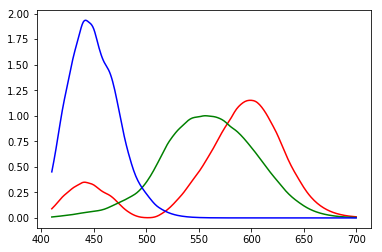

In [79]:
start_wl = 410
end_wl = 700
CIE = pd.read_csv("CIE1931.csv")
CIE.columns = ["wl","R","G","B"]
x = start_wl - 391
y = end_wl - 390
CIE = CIE[x:y].reset_index(drop = True)
wl = np.linspace(start_wl, end_wl, end_wl-start_wl+1)
plt.plot(wl, CIE['R'], 'r', wl, CIE['G'], 'g', wl, CIE['B'], 'b')
plt.show()

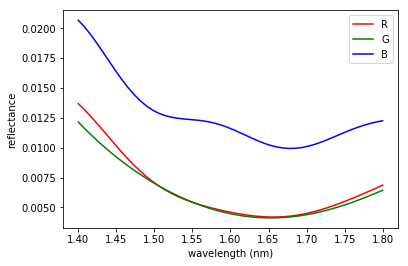

In [99]:
nn = np.linspace(1.4, 1.8)
R_avg = []
R_CIE = []
R_CR = []
R_CG = []
R_CB = []
for ni in nn:
    def acrylic_h(m, x):
        n = ni*np.ones(np.size(x))
        k = 0*np.ones(np.size(x))
        return n, k
    bridge = ThinFilm_model(
    {'a': 'polymide'}, [
        {'m': 'acrylic', 'd': 800},
        {'m': 'SiN', 'd': d_SiN},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'ITO', 'd':23},
        {'m': 'acrylic_h', 'd':1200},
        {'m': 'ITO', 'd':23},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiN', 'd': d_SiN}
    ], {'s': 'sodalime'}, wl)
    
    R_b = bridge.R().avg
    R_cie_avg = R_b*(CIE['R']+CIE['G']+CIE['B'])
    R_cie_r = R_b*CIE['R']
    R_cie_g = R_b*CIE['G']
    R_cie_b = R_b*CIE['B']
    R_avg.append(sum(R_b)/np.size(wl))
    R_CIE.append(sum(R_cie_avg)/np.size(wl))
    R_CR.append(sum(R_cie_r)/np.size(wl))
    R_CG.append(sum(R_cie_g)/np.size(wl))
    R_CB.append(sum(R_cie_b)/np.size(wl))

#plt.plot(nn, R_avg, 'k', label = "w/o color matching")
#plt.plot(nn, R_CIE, 'r--', label = 'w/ color matching')
plt.plot(nn, R_CR, 'r', label = 'R')
plt.plot(nn, R_CG, 'g', label = 'G')
plt.plot(nn, R_CB, 'b', label = 'B')
plt.legend(loc = 'best')
plt.ylabel('reflectance')
plt.xlabel('wavelength (nm)')
plt.savefig("RGB_matching.png")
plt.show()
